In [1]:
#%matplotlib widget
import numpy as np
from numpy.random import Generator, PCG64
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import h5py
from pyFCI import pyFCI

from sklearn.neighbors import KernelDensity

from lfci_functions import *
from utils import makedirs

In [2]:
from matplotlib import font_manager
font_file = "/usr/share/fonts/avenir_ff/AvenirLTStd-Roman.ttf"
font_file_b = "/usr/share/fonts/avenir_ff/AvenirLTStd-Black.ttf"
font_file_c = "/usr/share/fonts/avenir_ff/AvenirLTStd-Book.ttf"
font_manager.fontManager.addfont(font_file)
font_manager.fontManager.addfont(font_file_b)
font_manager.fontManager.addfont(font_file_c)
my_style = {
    #'font.family': 'DejaVu Serif',
    'font.family': 'Avenir LT Std',
    #'font.sans-serif':  "Avenir",
    'font.size': 10,
    'axes.labelsize': 22,
    'axes.linewidth': 1.5,
    'axes.titlesize': 30,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'image.cmap': 'jet',
}
plt.style.use(my_style)

# Functions

In [3]:
def compute_n_centers_neighborhood(neighborhoods,l_dataset, n_neighborhoods, coefficient=50):
    inverse_fraction = 1/(neighborhoods / l_dataset)
    n_centers_max = int(inverse_fraction.max())
    n_centers_min = int(inverse_fraction.min()*coefficient)
    n_centers_for_neighborhoods = np.floor(np.logspace(np.log2(n_centers_min), np.log2(n_centers_max), n_neighborhoods, base=2)).astype(int)
    n_centers_for_neighborhoods = np.flip(n_centers_for_neighborhoods)
    return n_centers_for_neighborhoods, n_centers_min, n_centers_max


In [4]:
def compute_all_deltas(dataset, n_centers_for_neighborhoods, neighborhoods,neighbors_indices):
    max_n_centers = max(n_centers_for_neighborhoods)
    n_neighborhoods = len(neighborhoods)
    deltas = np.zeros((max_n_centers,n_neighborhoods))
    distances,_ = KDTree_neighbors_dist(dataset)
    for i in range(max_n_centers):
        for j,k in enumerate(neighborhoods):
            sample = dataset[neighbors_indices[i][:k]]
            bar_sample = sample.mean(axis=0)
            distances_selected = distances[neighbors_indices[i][:k]]
            mean_distances = distances_selected.mean()
            deltas[i,j] = compute_deltas(sample,bar_sample, mean_distances)
    return deltas


# Dataset Generation

In [5]:
compute = False
save = False

In [6]:
modeldir = "Model_datasets"
figure_folder = f"{modeldir}/Figures"
lfci_folder = f"{modeldir}/ID_results"

In [7]:
makedirs(modeldir)
makedirs(figure_folder)
makedirs(lfci_folder)

## 2D Plane

In [8]:
N_points = 10000
if compute:
    rng = np.random.default_rng(1234)
    plane = rng.uniform(0, 1, (N_points,2))
    print(plane.shape)
    plane_embedded = np.zeros((N_points,3))
    plane_embedded[:, :2] = plane
else:
    plane_embedded = np.load(f"{modeldir}/plane_embedded.npy")

In [9]:
if save:
    np.save(f"{modeldir}/plane_embedded.npy", plane_embedded)

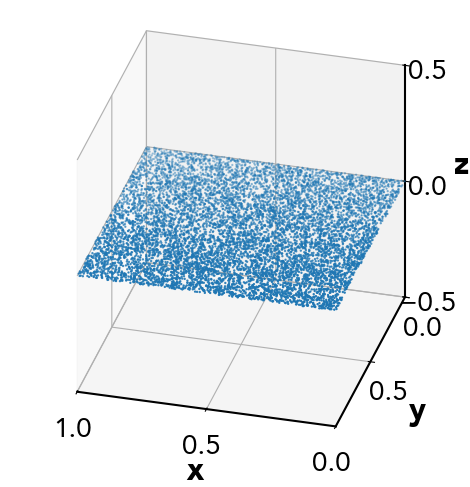

In [10]:
fig = plt.figure(figsize=(4.8,4.8),tight_layout=True)
ax = fig.add_subplot(projection='3d')
ax.scatter(plane_embedded[:, 0], plane_embedded[:, 1], plane_embedded[:, 2], s=0.5)
ax.set_xlabel("x",fontweight="bold", labelpad=8)
ax.set_ylabel("y",fontweight="bold", labelpad=10)
ax.set_zlabel("z",fontweight="bold", labelpad=8)
ax.set_proj_type('ortho')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set_zlim(-0.5, 0.5)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5])
ax.set_zticks([-0.5, 0, 0.5])
ax.view_init(30, 105)
ax.set_aspect("equal")
#plt.savefig(f"{modelddir}/plane_3d.pdf")
#plt.savefig(f"{modelddir}/plane_3d.png", dpi=300)
plt.show()

## Swiss Roll 

The swiss roll equation is:

$$
x = \phi\cos(\phi)$$
$$
y = \phi \sin(\phi)$$
$$
z = \psi$$
with $\phi$ random variable uniformly distributed in $1.5\pi<\phi<4.5\pi$ and  $\psi$ random variable uniformly distributed in $0<\psi<21\pi$.

This point generation affects the points density with an higher density in the central part of the swiss roll.

In [11]:
from sklearn.datasets import make_swiss_roll

In [12]:
n_samples = 30000
if compute:
    swiss_roll, t = make_swiss_roll(n_samples, noise=0., random_state=1)
else:
    file = np.load(f"{modeldir}/swiss_roll.npz")
    swiss_roll = file["swiss_roll"]
    t = file["t"]


In [13]:
if save:
    np.savez(f"{modeldir}/swiss_roll.npz", swiss_roll=swiss_roll,t=t)

In [14]:
nnd = KDTree_neighbors_dist(swiss_roll, n_neighbors=20)[0][:,-1]
nnd_min, nnd_max = nnd.min(), nnd.max()

In [15]:
print(nnd_min, nnd_max, nnd.mean(), nnd.std())
vmin = nnd.mean() - nnd.std()
vmax = nnd.mean() + nnd.std()
print(vmin, vmax)

0.30563371899970965 1.4771268431211473 0.6118292004372086 0.12123500430950296
0.4905941961277056 0.7330642047467115


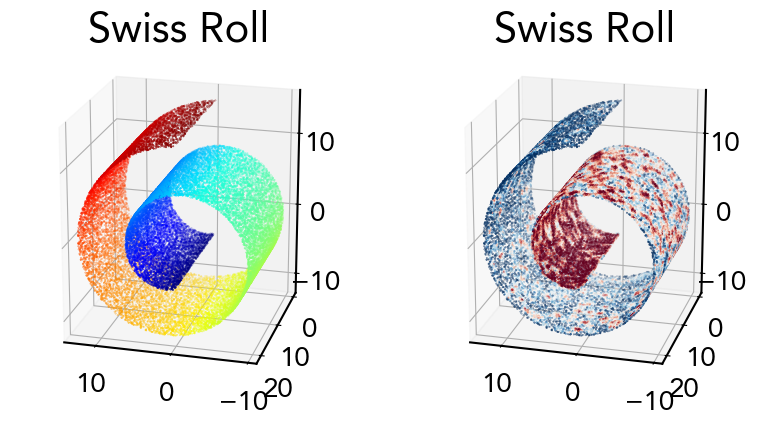

In [16]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c=t, cmap= 'jet')
ax.set_title("Swiss Roll")
ax.view_init(20, 105)
ax.set_aspect("equal")
ax1 = fig.add_subplot(1,2,2, projection='3d')
ax1.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c=nnd, vmin=vmin, vmax=vmax, cmap= 'RdBu')
ax1.set_title("Swiss Roll")
ax1.view_init(20, 105)
ax1.set_aspect("equal")
plt.show()

# lFCI

In [17]:
min_neighborhood_size = 40
max_neighborhood_size = 7500
n_neighborhoods = 12
delta_thr = 3
gof_thr = 0.02

## Swiss Roll

### Preprocessing

In [18]:
n_neighborhoods_sr = 16
max_neighborhood_size_sr = 9000
neighborhoods_swiss = np.logspace(np.log2(min_neighborhood_size), np.log2(max_neighborhood_size_sr), n_neighborhoods_sr,base=2,dtype=int)+1
print(neighborhoods_swiss)


[  41   58   83  119  170  244  350  501  719 1032 1480 2124 3047 4372
 6273 9000]


In [19]:
n_centers_neighborhoods_sr, n_centers_min_sr, n_centers_max_sr = compute_n_centers_neighborhood(neighborhoods_swiss,n_samples, n_neighborhoods_sr, coefficient=8)
n_total_centers_sr = np.sum(n_centers_neighborhoods_sr)
print(n_centers_neighborhoods_sr)

[730 585 468 375 300 240 192 154 123  98  79  63  50  40  32  25]


In [20]:
rng = np.random.default_rng(seed=123)
centers_sr = rng.choice(n_samples, n_centers_max_sr, replace=False)

### FCI

In [21]:
if compute:
    ID_FCI_swiss, GoF_swiss = compute_id(swiss_roll[::2], return_gof = True, n_fit_points=5000)
else:
    ID_FCI_swiss, GoF_swiss = np.load(f"{modeldir}/ID_swiss_roll.npy")
print(ID_FCI_swiss, GoF_swiss)

2.724587881728091 0.01399114661319505


In [22]:
if save:
    np.save(f"{modeldir}/ID_swiss_roll.npy", np.array([ID_FCI_swiss, GoF_swiss]))

### lFCI

In [23]:
if compute:
    ids_swiss, distances_swiss, indexes_neighborhood_swiss = local_fci_distance_fast(swiss_roll, centers_sr, n_centers_neighborhoods_sr, neighborhoods_swiss, fci_method="full", n_jobs=4,n_fit_points=5000) 

In [24]:
file_name_sr = "lFCI_swiss_roll.h5"

In [25]:
if save:
    with h5py.File(f"{lfci_folder}/{file_name_sr}", "w") as f:
        f["local_ids"] = ids_swiss
        f["selected_distances"] = distances_swiss
        f["neighbor_indices"] = indexes_neighborhood_swiss
        f["centers"] = centers_sr
        f["n_centers_neigh"] = n_centers_neighborhoods_sr
        f["neighborhoods"] = neighborhoods_swiss

In [26]:
if  not compute:
    with h5py.File(f"{lfci_folder}/{file_name_sr}", "r") as f:
        ids_swiss = f["local_ids"][:]
        distances_swiss = f["selected_distances"][:]
        indexes_neighborhood_swiss = f["neighbor_indices"][:]
        centers_sr =f["centers"][:]
        n_centers_neighborhoods_sr = f["n_centers_neigh"][:]
        neighborhoods_swiss = f["neighborhoods"][:]

### Postprocessing 

In [27]:
local_ids_2d_sr, GoF_sr, k_sr = unwrap_local_ids(ids_swiss)

In [28]:
weights_sr = compute_weights(n_centers_neighborhoods_sr)

In [29]:
local_fci_sr_flat = flatten_variable(local_ids_2d_sr,n_centers_neighborhoods_sr, n_total_centers_sr)
gof_sr_flat = flatten_variable(GoF_sr,n_centers_neighborhoods_sr, n_total_centers_sr)
weights_sr_flat = flatten_variable(weights_sr,n_centers_neighborhoods_sr, n_total_centers_sr)
k_sr_flat = flatten_variable(k_sr,n_centers_neighborhoods_sr, n_total_centers_sr, dtype=int)

In [30]:
deltas_swiss = compute_all_deltas(swiss_roll, n_centers_neighborhoods_sr, neighborhoods_swiss, indexes_neighborhood_swiss)

In [31]:
deltas_sr_flat = flatten_variable(deltas_swiss,n_centers_neighborhoods_sr, n_total_centers_sr)

In [32]:
median_delta_swiss = np.median(deltas_swiss, axis=0)
print(median_delta_swiss)

[ 0.54932717  0.56773373  0.58199387  0.63762483  0.72271406  0.83905427
  1.02658486  1.35623258  1.83977944  2.58393437  3.87906562  6.23105213
  8.82508963 12.04747718 14.6780117  11.55951935]


In [33]:
cond_sr = (gof_sr_flat<gof_thr)&(deltas_sr_flat<delta_thr)
idx_good_sr = np.where(cond_sr)
idx_bad_sr = np.where(~cond_sr)

In [34]:
k_sr_good = k_sr_flat[idx_good_sr]
k_sr_bad = k_sr_flat[idx_bad_sr]
local_fci_sr_good = local_fci_sr_flat[idx_good_sr]
local_fci_sr_bad = local_fci_sr_flat[idx_bad_sr]
weights_sr_good = weights_sr_flat[idx_good_sr]

### Visualization

#### Deltas *vs* #Neighbors

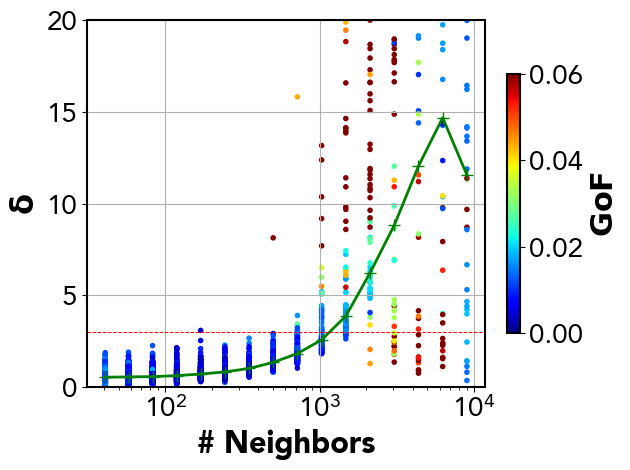

In [35]:
fig, ax = plt.subplots(tight_layout=True)
AA = ax.scatter(k_sr_flat,deltas_sr_flat, c=gof_sr_flat,vmin=0,vmax=0.06, cmap="jet", s=9)
ax.plot(neighborhoods_swiss, median_delta_swiss,"-+", c="green", lw=2)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
ax.set_ylim(0,20)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.axhline(3, ls="--", lw=0.7,c="r")
plt.savefig(f"{figure_folder}/swiss_roll_deltas_neighbors.pdf")
plt.show()

#### ID *vs* #Neighbors

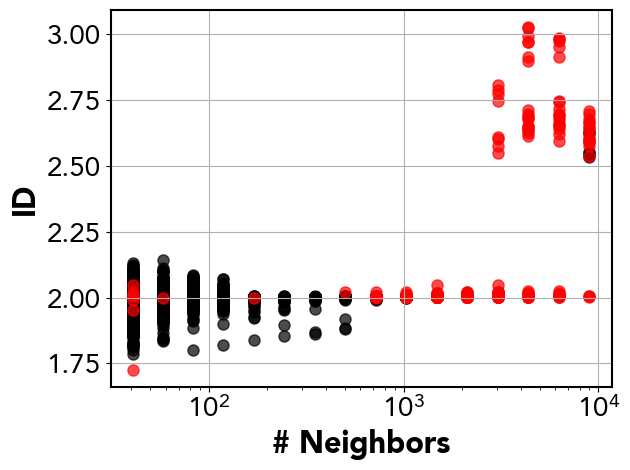

In [36]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_sr_good,local_fci_sr_good,c="k", alpha=0.7)
ax.scatter(k_sr_bad,local_fci_sr_bad,c="r", alpha=0.7)
ax.grid()
#ax.set_ylim(1,3.5)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.savefig(f"{figure_folder}/swissroll_IDvsNeighborhood_good_bad.pdf")

plt.show()

#### Values Distribution

In [37]:
hist_g_swiss, bin_edges_g_swiss = np.histogram(local_fci_sr_good,range=(1.5,3.5), bins=20, weights=weights_sr_good)

In [38]:
hist_all_swiss, bin_edges_all_swiss = np.histogram(local_fci_sr_flat,range=(1.5,3.5), bins=20, weights=weights_sr_flat)

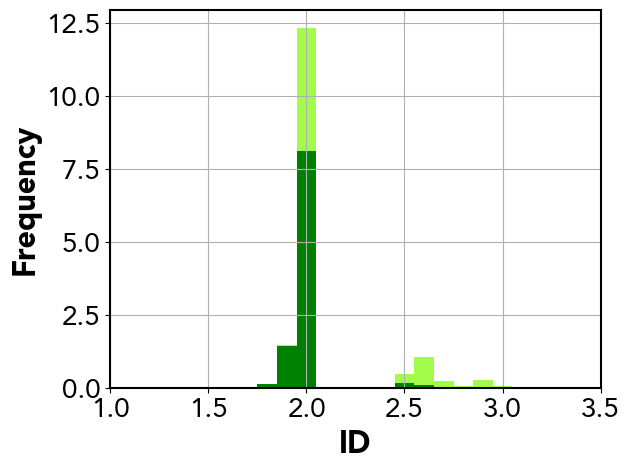

In [39]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_all_swiss[:-1], hist_all_swiss, width=np.diff(bin_edges_all_swiss), color="lawngreen", alpha=0.7)
plt.bar(bin_edges_g_swiss[:-1], hist_g_swiss, width=np.diff(bin_edges_g_swiss), color="g")
ax.grid()
ax.set_xlim(1,3.5)
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
plt.savefig(f"{figure_folder}/swissroll_hist_good.pdf")
plt.show()

In [40]:
ids_sr_gof = local_fci_sr_flat[gof_sr_flat<0.02]
deltas_sr_gof = deltas_sr_flat[gof_sr_flat<0.02]
weight_sr_gof = weights_sr_flat[gof_sr_flat<0.02]
delta_thr = 3
kde = KernelDensity(bandwidth=0.3).fit(ids_sr_gof[deltas_sr_gof<delta_thr].reshape(-1,1),
                 sample_weight=weight_sr_gof[deltas_sr_gof<delta_thr])
x_kde = np.linspace(0,10,300)
log_den = kde.score_samples(x_kde.reshape(-1,1))
peak = x_kde[np.argmax(log_den)]

print(f"ID local = {peak:.2f}")

ID local = 2.01


### Consideration about bad values

In [41]:
print(k_sr_bad.shape, local_fci_sr_bad.shape)

(325,) (325,)


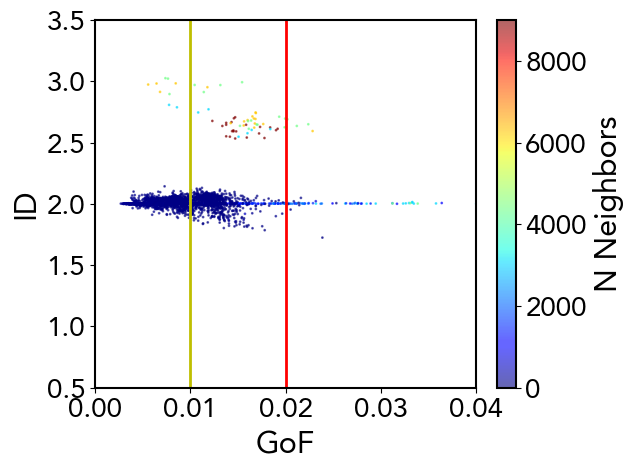

In [42]:
fig, ax = plt.subplots(tight_layout=True)
aa = ax.scatter(GoF_sr, local_ids_2d_sr, c=k_sr, s=1, cmap="jet", alpha = 0.6)
plt.colorbar(aa, ax=ax, fraction=0.05, label="N Neighbors")
ax.set_xlabel("GoF")
ax.set_ylabel("ID")
ax.axvline(0.02, color="r")
ax.axvline(0.01, color="y")
ax.set_xlim(0,0.04)
ax.set_ylim(0.5,3.5)
#ax.legend()
plt.show()

In [43]:
idx_verybad = np.where((GoF_sr>0.02)&(local_ids_2d_sr>2.5))
print(idx_verybad[0].shape, idx_verybad[1].shape)

(4,) (4,)


In [44]:
idx_verybad = np.where((GoF_sr>0.02)&(local_ids_2d_sr>2.5))
print(idx_verybad)
gof_verybad = GoF_sr[idx_verybad[0],idx_verybad[1]]
print(gof_verybad)
idx_c_verybad = centers_sr[idx_verybad[0]]
k_verybad = neighborhoods_swiss[idx_verybad[1]]
print(idx_c_verybad, k_verybad)

(array([ 3, 19, 21, 31]), array([14, 13, 13, 13]))
[0.02283341 0.02018605 0.02117505 0.02237953]
[ 8361 24442  1180 13039] [6273 4372 4372 4372]


In [45]:
idx_gof_vb_sorted = np.argsort(-gof_verybad)
gof_verybad_sorted = gof_verybad[idx_gof_vb_sorted]
idx_verybad_sorted = [idx_verybad[0][idx_gof_vb_sorted], idx_verybad[1][idx_gof_vb_sorted]]
k_verybad_sorted = k_verybad[idx_gof_vb_sorted]
idx_c_verybad_sorted = idx_c_verybad[idx_gof_vb_sorted]

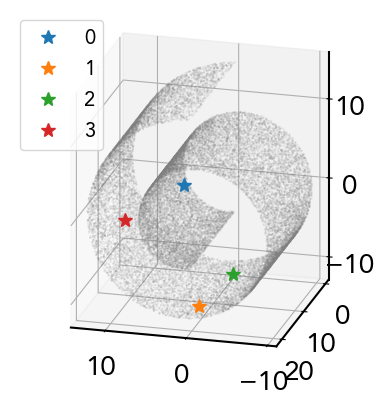

In [46]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
for i,idx_vb in enumerate(idx_c_verybad_sorted):
    ax.plot(swiss_roll[idx_vb,0],swiss_roll[idx_vb,1],swiss_roll[idx_vb,2], "*", ms=10, zorder=3,label=i)
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.legend(loc="upper left", fontsize="x-large")
ax.view_init(20, 105)
ax.set_aspect("equal")
ax.set_proj_type('ortho')
#plt.savefig(f"{figure_folder}/swiss_roll_neighborhoods.pdf")
plt.show()


In [47]:
l = 0
idx_worse = [idx_verybad_sorted[0][l],idx_verybad_sorted[1][l]]
gof_worse = gof_verybad_sorted[l]
local_fci_worse = local_ids_2d_sr[idx_worse[0],idx_worse[1]]
k_worse = k_verybad_sorted[l]
delta_worse = deltas_swiss[idx_worse[0],idx_worse[1]]
idx_c_worse = centers_sr[idx_worse[0]]

In [48]:
print(f"Worse fit:\nidx = {idx_worse}\nGoF = {gof_worse}\nlocal FCI = {local_fci_worse}\nk = {k_worse}\ndelta = {delta_worse}\npoint idx = {idx_c_worse}")

Worse fit:
idx = [3, 14]
GoF = 0.022833408787846565
local FCI = 2.594165802001953
k = 6273
delta = 4.017028078791834
point idx = 8361


In [49]:
print(swiss_roll[idx_c_worse])

[ 5.89090442  1.54962892 -1.38690766]


In [50]:
indexes_neigh_worse = indexes_neighborhood_swiss[idx_worse[0],:k_worse]

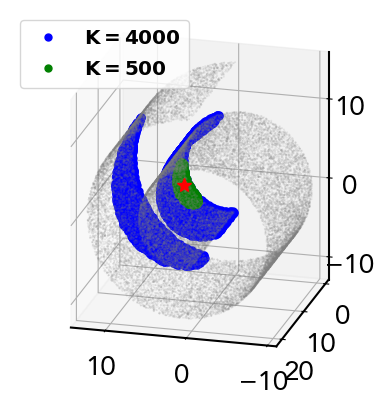

In [51]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(swiss_roll[indexes_neigh_worse,0],swiss_roll[indexes_neigh_worse,1],swiss_roll[indexes_neigh_worse,2], "o", ms=5, c="b", label=r"$\mathbf{K=4000}$", zorder=1)
ax.plot(swiss_roll[indexes_neigh_worse[:500],0],swiss_roll[indexes_neigh_worse[:500],1],swiss_roll[indexes_neigh_worse[:500],2], "o", ms=5, c="g",label=r"$\mathbf{K=500}$",zorder=2)
ax.plot(swiss_roll[idx_c_worse,0],swiss_roll[idx_c_worse,1],swiss_roll[idx_c_worse,2], "*", ms=10, c="r",zorder=3)
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
#ax.scatter(dataset_z[:, 0], dataset_z[:, 1], dataset_z[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.view_init(20, 105)
#ax.set_xlim(-5,10)
#ax.set_zlim(-7,4)
ax.legend(loc="upper left", fontsize="x-large")
ax.set_aspect("equal")
ax.set_proj_type('ortho')
plt.savefig(f"{figure_folder}/swiss_roll_neighborhoods.pdf")
plt.show()


In [52]:
dataset_x = swiss_roll[(swiss_roll[:,0]>0)]#&(swiss_roll[:,0]<7)]
dataset_y = dataset_x
#dataset_z = dataset_y[(dataset_y[:,2]>-7)&(dataset_y[:,2]<3)]
dataset_z = dataset_y

In [53]:
dataset_z = swiss_roll[(swiss_roll[:,2]<0)]#&(swiss_roll[:,2]<7)]

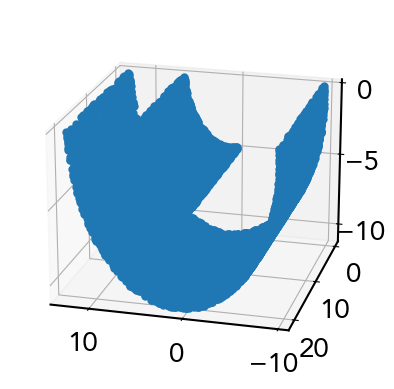

In [54]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(dataset_z[:,0],dataset_z[:,1],dataset_z[:,2], "o", ms=5, zorder=1)
ax.view_init(20, 105)
plt.show()

In [55]:
neighborhood_good = indexes_neigh_worse[:500]
neighborhood_bad = indexes_neigh_worse
print(neighborhood_good.shape,neighborhood_bad.shape )

(500,) (6273,)


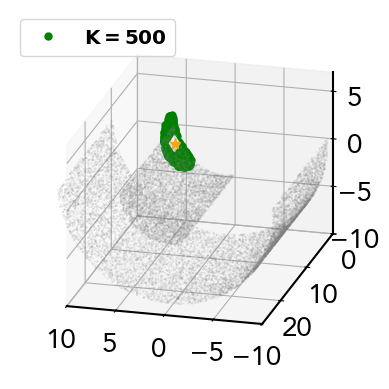

In [56]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
swiss_roll_good = swiss_roll[neighborhood_good]
barycenter_good = np.mean(swiss_roll_good, axis=0)
ax.plot(swiss_roll_good[:,0],swiss_roll_good[:,1],swiss_roll_good[:,2], "o", ms=5, c="g",label=r"$\mathbf{K=500}$",zorder=1)
ax.plot(swiss_roll[idx_c_worse,0],swiss_roll[idx_c_worse,1],swiss_roll[idx_c_worse,2], "d", ms=8, c="white",zorder=2)
ax.plot(barycenter_good[0],barycenter_good[1],barycenter_good[2], "*", ms=8, c="orange",zorder=3)
#ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.scatter(dataset_z[:, 0], dataset_z[:, 1], dataset_z[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.view_init(20, 105)
ax.set_xlim(-10,10)
ax.set_zlim(-10,7)
ax.set_ylim(0,27)
ax.legend(loc="upper left", fontsize="x-large")
ax.view_init(20, 105)
ax.set_aspect("equal")
ax.set_proj_type('ortho')
plt.savefig(f"{figure_folder}/swiss_roll_neighborhoods_good.pdf")
plt.show()


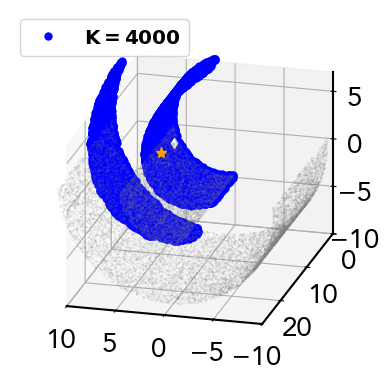

In [57]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
swiss_roll_bad = swiss_roll[neighborhood_bad]
barycenter_bad = np.mean(swiss_roll_bad, axis=0)
ax.plot(swiss_roll_bad[:,0],swiss_roll_bad[:,1],swiss_roll_bad[:,2], "o", ms=5, c="b", label=r"$\mathbf{K=4000}$", zorder=1)
ax.plot(swiss_roll[idx_c_worse,0],swiss_roll[idx_c_worse,1],swiss_roll[idx_c_worse,2], "d", ms=5, c="white",zorder=2)
ax.plot(barycenter_bad[0],barycenter_bad[1],barycenter_bad[2], "*", ms=8, c="orange",zorder=3)
#ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.scatter(dataset_z[:, 0], dataset_z[:, 1], dataset_z[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)

ax.view_init(20, 105)
ax.set_xlim(-10,10)
ax.set_zlim(-10,7)
ax.set_ylim(0,27)
ax.legend(loc="upper left", fontsize="x-large")
#ax.view_init(20, 105)
ax.set_aspect("equal")
ax.set_proj_type('ortho')
plt.savefig(f"{figure_folder}/swiss_roll_neighborhoods_bad.pdf")
plt.show()

In [58]:
x_fci = np.linspace(0,2,2000)

In [59]:
norm_good = pyFCI.center_and_normalize(swiss_roll[neighborhood_good])
fci_good = pyFCI.FCI(norm_good)
id_good,_, gof_good = pyFCI.fit_FCI(fci_good)
y_fci_good = pyFCI.analytical_FCI(x_fci,id_good-1)
print(id_good, gof_good)

2.064143174892541 0.0061881875323815455


In [60]:
norm_bad = pyFCI.center_and_normalize(swiss_roll[neighborhood_bad])
fci_bad = pyFCI.FCI(norm_bad)
id_bad,_, gof_bad = pyFCI.fit_FCI(fci_bad,5000)
print(id_bad, gof_bad)

2.0018678541371795 0.06757492085704395


In [61]:
id_bad_array = np.zeros(10)
gof_bad_array = np.zeros(10)
for i in range(10):
    id_bad,_, gof_bad = pyFCI.fit_FCI(fci_bad,5000)
    id_bad_array[i] = id_bad
    gof_bad_array[i] = gof_bad
    print(id_bad, gof_bad)
    

2.008234322041042 0.06739351581501503
2.0033341696235354 0.06675143925984675
2.0026593867291798 0.06750797781317448
2.0033115555486445 0.06724778633145617
2.592602549301831 0.022698250290703107
2.001446613036255 0.06806458002311284
2.0033866287618634 0.06750827844006464
2.0034866113497003 0.067780520101282
2.0016464745593083 0.06746172009197053
2.0068081704709533 0.06758858768628259


In [62]:
print(f"{idx_c_worse}, {gof_worse:.5f}, {local_fci_worse:.5f},{delta_worse:.5f}", k_worse)

8361, 0.02283, 2.59417,4.01703 6273


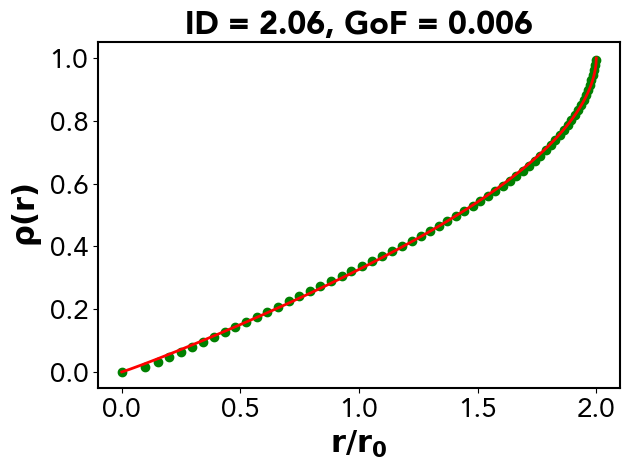

In [63]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(fci_good[::2000,0], fci_good[::2000,1],"o",ms=6,c="g")
ax.plot(x_fci,y_fci_good, lw=2,c="r")
ax.set_xlabel(r"$\mathbf{r/r_0}$")
ax.set_ylabel(r"$\mathbf{\rho(r)}$")
ax.set_title(f"ID = {id_good:.2f}, GoF = {gof_good:.3f}", fontweight="bold",fontsize="23")
plt.savefig(f"{figure_folder}/swiss_roll_good_fit_K500_new.pdf")
plt.show()

In [64]:
idx_bad_as_before = np.where((gof_bad_array>0.02)&(id_bad_array>2.5))[0][0]
print(idx_bad_as_before)
id_bad = id_bad_array[idx_bad_as_before]
gof_bad = gof_bad_array[idx_bad_as_before]
print(id_bad, gof_bad)
y_fci_bad = pyFCI.analytical_FCI(x_fci,id_bad-1)

4
2.592602549301831 0.022698250290703107


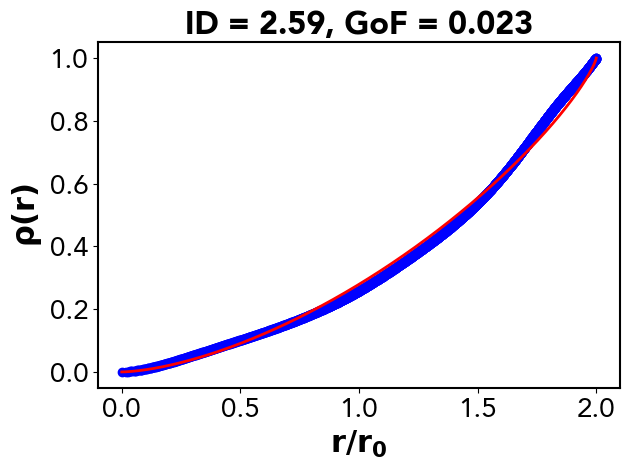

In [65]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(fci_bad[::10000,0], fci_bad[::10000,1],"o",ms=6,c="b")
ax.plot(x_fci,y_fci_bad,lw=2,c="r")
ax.set_xlabel(r"$\mathbf{r/r_0}$")
ax.set_ylabel(r"$\mathbf{\rho(r)}$")
ax.set_title(f"ID = {id_bad:.2f}, GoF = {gof_bad:.3f}", fontweight="bold",fontsize="23")
plt.savefig(f"{figure_folder}/swiss_roll_bad_fit_K3000_new.pdf")
plt.show()

## 2D Plane

### Preprocessing

In [66]:
neighborhoods_plane = np.logspace(np.log2(min_neighborhood_size), np.log2(max_neighborhood_size), n_neighborhoods,base=2,dtype=int)+1
print(neighborhoods_plane)


[  41   65  104  167  269  432  695 1119 1800 2896 4661 7500]


In [67]:
n_centers_neighborhoods_p, n_centers_min_p, n_centers_max_p = compute_n_centers_neighborhood(neighborhoods_plane,N_points, n_neighborhoods, coefficient=30)
n_total_centers_p = np.sum(n_centers_neighborhoods_p)
print(n_centers_neighborhoods_p)

[243 206 175 148 126 107  90  77  65  55  47  40]


In [68]:
rng = np.random.default_rng(seed=1233)
centers_p = rng.choice(N_points, n_centers_max_p, replace=False)

### FCI 

In [69]:
if compute:
    ID_FCI_plane, GoF = compute_id(plane_embedded, return_gof=True)
else:
    ID_FCI_plane, GoF = np.load(f"{lfci_folder}/ID_FCI_plane.npy")
print(ID_FCI_plane, GoF)

1.9939846790028621 0.002204783869017059


In [70]:
if save:
    np.save(f"{lfci_folder}/ID_FCI_plane.npy", np.array([ID_FCI_plane, GoF]))

### lFCI

In [71]:
if compute:
    ids_plane, distances_plane, indexes_neighborhood_plane = local_fci_distance_fast(plane_embedded, centers_p, n_centers_neighborhoods_p, neighborhoods_plane, fci_method="full", n_jobs=4) 

In [72]:
file_name_p = "lFCI_plane.h5"

In [73]:
if save:
    with h5py.File(f"{lfci_folder}/{file_name_p}", "w") as f:
        f["local_ids"] = ids_plane
        f["selected_distances"] = distances_plane
        f["neighbor_indices"] = indexes_neighborhood_plane
        f["centers"] = centers_p
        f["n_centers_neigh"] = n_centers_neighborhoods_p
        f["neighborhoods"] = neighborhoods_plane

In [74]:
if  not compute:
    with h5py.File(f"{lfci_folder}/{file_name_p}", "r") as f:
        ids_plane = f["local_ids"][:]
        distances_plane = f["selected_distances"][:]
        indexes_neighborhood_plane = f["neighbor_indices"][:]
        centers_p =f["centers"][:]
        n_centers_neighborhoods_p = f["n_centers_neigh"][:]
        neighborhoods_plane = f["neighborhoods"][:]

### Postprocessing 

In [75]:
local_ids_2d_p, GoF_p, k_p = unwrap_local_ids(ids_plane)

In [76]:
weights_p = compute_weights(n_centers_neighborhoods_p)

In [77]:
local_fci_p_flat = flatten_variable(local_ids_2d_p,n_centers_neighborhoods_p, n_total_centers_p)
gof_p_flat = flatten_variable(GoF_p,n_centers_neighborhoods_p, n_total_centers_p)
weights_p_flat = flatten_variable(weights_p,n_centers_neighborhoods_p, n_total_centers_p)
k_p_flat = flatten_variable(k_p,n_centers_neighborhoods_p, n_total_centers_p,dtype="int")

In [78]:
deltas_plane = compute_all_deltas(plane_embedded, n_centers_neighborhoods_p, neighborhoods_plane,indexes_neighborhood_plane)

In [79]:
deltas_p_flat = flatten_variable(deltas_plane,n_centers_neighborhoods_p, n_total_centers_p)

In [80]:
median_delta_plane = np.median(deltas_plane, axis=0)
print(median_delta_plane)

[0.58674648 0.56703554 0.59591464 0.63054887 0.72575944 0.71522571
 0.7147498  0.79281754 0.81039605 0.84300933 0.9213283  1.05176986]


In [81]:
cond_p = (gof_p_flat<gof_thr)&(deltas_p_flat<delta_thr)
idx_good_p = np.where(cond_p)
idx_bad_p = np.where(~cond_p)

In [82]:
k_p_good = k_p_flat[idx_good_p]
k_p_bad = k_p_flat[idx_bad_p]
local_fci_p_good = local_fci_p_flat[idx_good_p]
local_fci_p_bad = local_fci_p_flat[idx_bad_p]
weights_p_good = weights_p_flat[idx_good_p]

### Visualization

#### Deltas *vs* #Neighbors

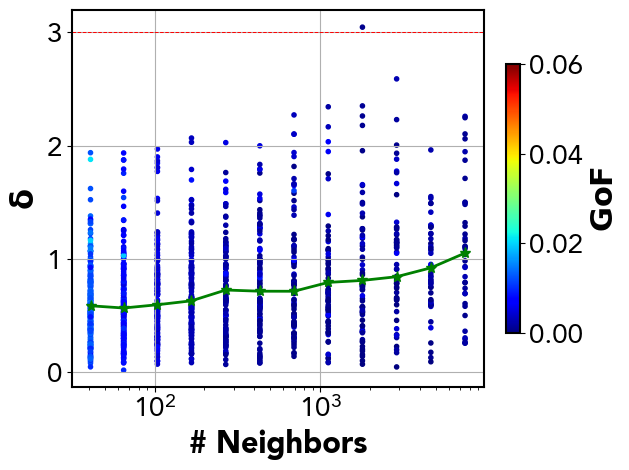

In [83]:
fig, ax = plt.subplots(tight_layout=True)
AA = ax.scatter(k_p_flat,deltas_p_flat, c=gof_p_flat,vmin=0,vmax=0.06, cmap="jet", s=9)
ax.plot(neighborhoods_plane, median_delta_plane,"*-", c="green", lw=2)
plt.colorbar(AA, fraction=0.03, label=r"$\mathbf{GoF}$")
ax.grid()
#ax.set_ylim(0,20)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel(r"$\mathbf{\delta}$",fontweight="bold")
ax.axhline(3,ls="--", lw=0.7, c="r")
plt.savefig(f"{figure_folder}/plane_deltas_neighbors.pdf")
plt.show()

#### ID *vs* #Neighbors

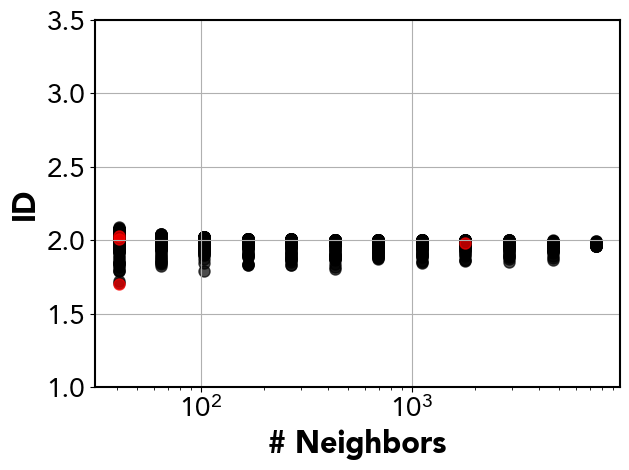

In [84]:
fig, ax = plt.subplots(tight_layout=True)
ax.scatter(k_p_good,local_fci_p_good,c="k", alpha=0.7)
ax.scatter(k_p_bad,local_fci_p_bad,c="r", alpha=0.7)
ax.grid()
ax.set_ylim(1,3.5)
ax.set_xscale("log")
ax.set_xlabel("# Neighbors",fontweight="bold")
ax.set_ylabel("ID",fontweight="bold")
plt.savefig(f"{figure_folder}/plane_IDvsNeighborhood_good_bad.pdf")
plt.show()

#### Values Distribution

In [85]:
hist_g_plane, bin_edges_g_plane = np.histogram(local_fci_p_good,range=(1.5,3.5), bins=20, weights=weights_p_good)

In [86]:
hist_all_plane, bin_edges_all_plane = np.histogram(local_fci_p_flat,range=(1.5,3.5), bins=20, weights=weights_p_flat)

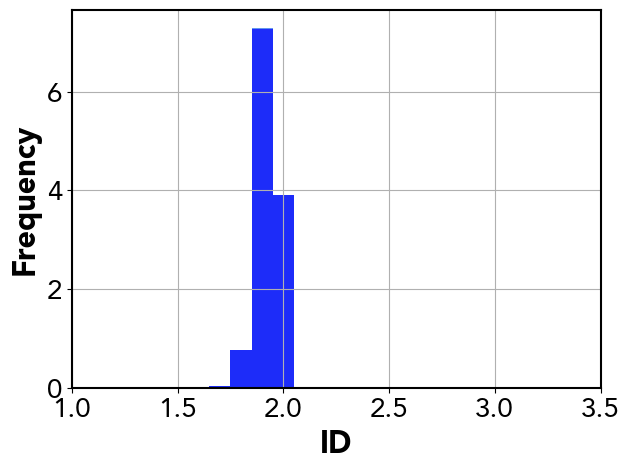

In [87]:
fig, ax = plt.subplots(tight_layout=True)
plt.bar(bin_edges_all_plane[:-1], hist_all_plane, width=np.diff(bin_edges_all_plane), color="cornflowerblue")
plt.bar(bin_edges_g_plane[:-1], hist_g_plane, width=np.diff(bin_edges_g_plane), color="b", alpha=0.7)
ax.grid()
ax.set_xlim(1,3.5)
ax.set_xlabel("ID", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
plt.savefig(f"{figure_folder}/plane_hist_good.pdf")
plt.show()

### Consideration about neighborhoods

In [88]:
idx_centers_p = np.argwhere((plane_embedded[centers_p,0]>0.45)&(plane_embedded[centers_p,0]<0.55)&(plane_embedded[centers_p,1]>0.45)&(plane_embedded[centers_p,1]<0.55))

In [89]:
print(idx_centers_p)
sel_centers_p = centers_p[idx_centers_p]
print(sel_centers_p)

[[71]
 [80]]
[[7740]
 [4321]]


In [90]:
l_p = 71
idx_c_plane = centers_p[l_p]
print(idx_c_plane) 

7740


In [91]:
indexes_neigh_plane = indexes_neighborhood_plane[l_p][:3000]

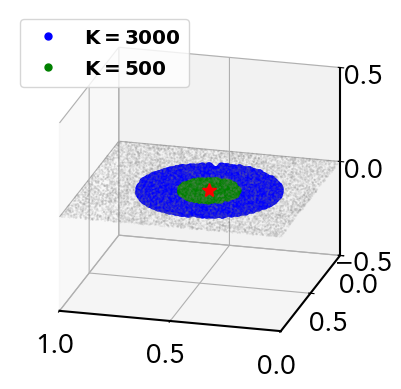

In [92]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(plane_embedded[indexes_neigh_plane,0],plane_embedded[indexes_neigh_plane,1],plane_embedded[indexes_neigh_plane,2], "o", ms=5, c="b", label=r"$\mathbf{K=3000}$", zorder=1)
ax.plot(plane_embedded[indexes_neigh_plane[:500],0],plane_embedded[indexes_neigh_plane[:500],1],plane_embedded[indexes_neigh_plane[:500],2], "o", ms=5, c="g", label=r"$\mathbf{K=500}$" ,zorder=2)
ax.plot(plane_embedded[idx_c_plane,0],plane_embedded[idx_c_plane,1],plane_embedded[idx_c_plane,2], "*", ms=10, c="r",zorder=3)
ax.scatter(plane_embedded[:, 0], plane_embedded[:, 1], plane_embedded[:, 2],s = 0.1, c="grey", alpha=0.2, zorder=0)
ax.legend(fontsize="x-large",loc='upper left')
ax.view_init(20, 105)
ax.set_zlim(-0.5, 0.5)
ax.set_aspect("equal")
ax.set_proj_type('ortho')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set_zlim(-0.5, 0.5)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5])
ax.set_zticks([-0.5, 0, 0.5])
plt.savefig(f"{figure_folder}/plane_neighborhoods.pdf")
plt.show()